### Welcome to the exercise about observational studies! This exercise will be hands on, and you will be able to practise the skills you developed so far!

## Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 6 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to deepen your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [24]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import scipy.stats as stats
import statsmodels.formula.api as smf
%matplotlib inline

data_folder = './data/'
df = pd.read_csv(data_folder + 'lalonde.csv')

## 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lecture 4 ("Descibing data") and 3 ("Visualizing data").

What might a naive "researcher" conclude from this superficial analysis?

In [4]:
df.sample(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
467,PSID283,0,23,8,0,0,1,1,33.30754,166.500,0.000
19,NSW20,1,26,12,1,0,0,0,0.00000,0.000,10747.350
368,PSID184,0,17,10,0,0,0,1,0.00000,1503.871,7843.773
77,NSW78,1,21,9,1,0,0,1,0.00000,0.000,0.000
466,PSID282,0,17,10,0,0,0,1,0.00000,171.871,1483.637
606,PSID422,0,16,9,0,0,0,1,0.00000,0.000,5551.819
327,PSID143,0,23,12,0,0,1,0,4954.98600,2771.419,0.000
376,PSID192,0,23,13,0,0,0,0,601.49490,1394.661,4975.505
173,NSW174,1,19,10,1,0,0,1,4121.94900,6056.754,0.000
230,PSID46,0,20,12,1,0,1,0,9555.34400,7055.661,0.000


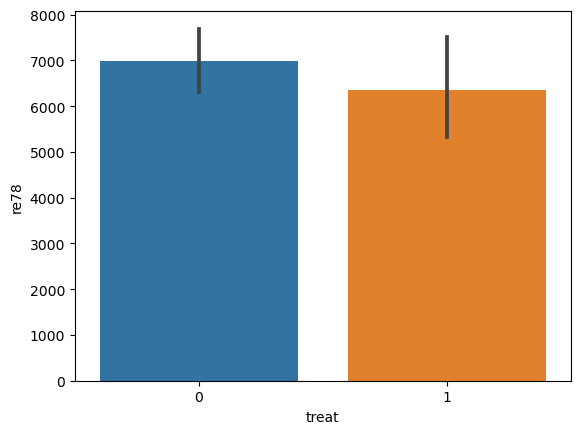

In [5]:
ax = sns.barplot(x='treat',y='re78',data=df)

In [7]:
stats.ttest_ind(df.loc[df['treat']==0]['re78'],df.loc[df['treat']==1]['re78'])

Ttest_indResult(statistic=0.966352225446378, pvalue=0.3342496685909654)

## 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

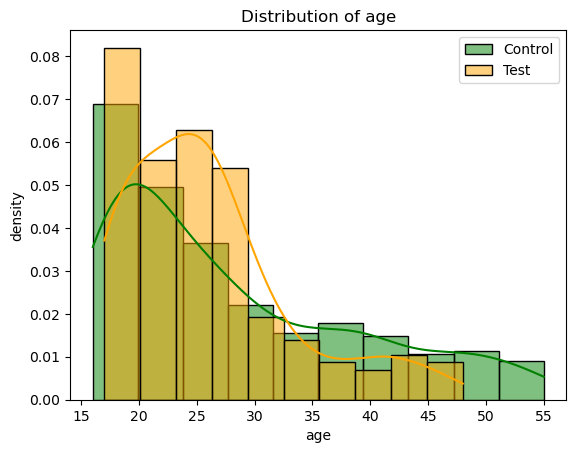

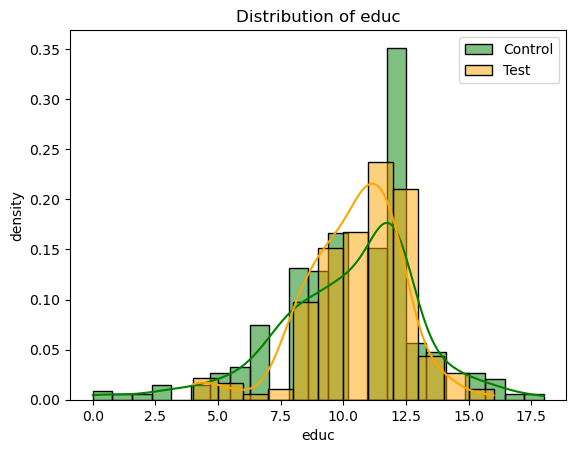

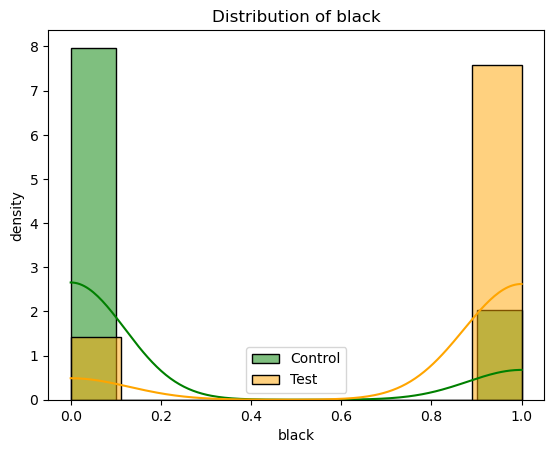

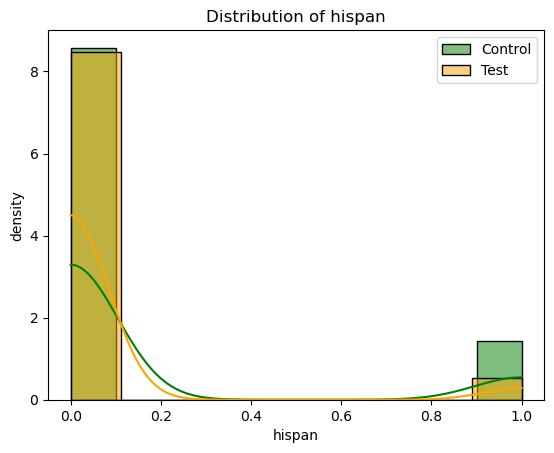

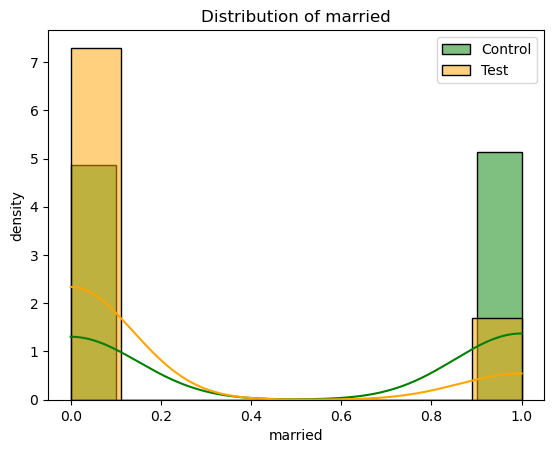

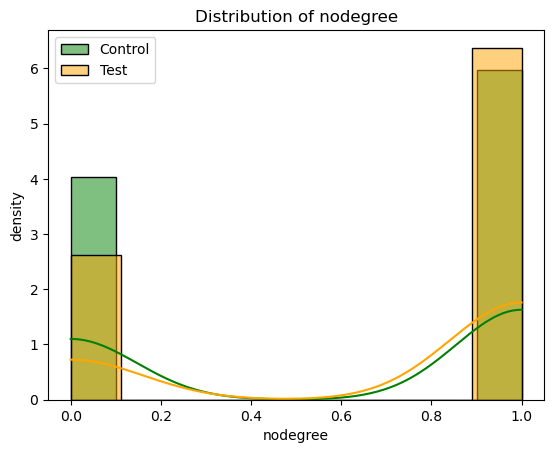

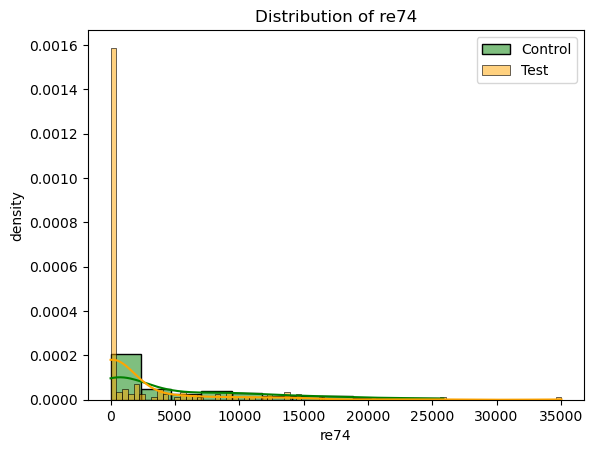

In [23]:
control=df.loc[df['treat']==0]
test=df.loc[df['treat']==1]

for cat in df.columns[2:9]:
    ax = sns.histplot(control[cat], kde=True, stat='density', label='Control',color='green')
    ax = sns.histplot(test[cat], kde=True, stat='density', label='Test', color='orange')
    ax.set(title= 'Distribution of '+cat,xlabel=cat,ylabel='density')
    plt.legend()
    plt.show()

In [20]:
df.columns

Index(['id', 'treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree',
       're74', 're75', 're78'],
      dtype='object')

## 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `statsmodels` to fit the logistic regression model and apply it to each data point to obtain propensity scores.

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).)

In [28]:
mod = smf.logit(formula='treat ~ age + educ + black + hispan + married + nodegree + re74 + re75', data=df)
res=mod.fit()

print(res.summary())

res.predict()

Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Sun, 20 Nov 2022   Pseudo R-squ.:                  0.3508
Time:                        14:12:57   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.7286      1.017     -4.649      0.000      -6.722      -2.735
age            0.0158      0.

array([0.63876993, 0.22463424, 0.67824388, 0.77632408, 0.70163875,
       0.6990699 , 0.65368426, 0.78972311, 0.77983825, 0.04292461,
       0.68901996, 0.682444  , 0.64986767, 0.56241073, 0.60858629,
       0.72249036, 0.70259562, 0.73496416, 0.71166489, 0.66431981,
       0.76517492, 0.13901525, 0.12238224, 0.76799791, 0.71931601,
       0.60916715, 0.77079713, 0.26920316, 0.71611962, 0.76799791,
       0.71611962, 0.6098168 , 0.59404299, 0.64289289, 0.66079247,
       0.77862159, 0.56093965, 0.45094835, 0.5567796 , 0.73802599,
       0.64650679, 0.09365296, 0.64626932, 0.09150549, 0.75656387,
       0.59404299, 0.64626932, 0.68221881, 0.56093965, 0.65368426,
       0.68486666, 0.61665323, 0.75070545, 0.66079247, 0.61291686,
       0.71611962, 0.7464048 , 0.37847866, 0.60480778, 0.13012192,
       0.64626932, 0.68826176, 0.7701718 , 0.77632408, 0.53662873,
       0.7186015 , 0.77632408, 0.07382733, 0.43251547, 0.70914659,
       0.71540019, 0.76123332, 0.57342619, 0.66079247, 0.76818

## 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

This is how networkx library can help you do this. Each possible pair of (treated_person, control_person) is characterized by a similarity. This is how we can initialize a graph, and add an edge for one possible pair. We then need to add an edge for each possible pair.
    - G = nx.Graph()
    - G.add_weighted_edges_from([(control_person, treated_person, similarity)])
Optimal matching is then found with:
    - matching = nx.max_weight_matching(G)

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In [30]:
df['treat'].value_counts()

0    429
1    185
Name: treat, dtype: int64

## 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


In [7]:
''' your code and explanations ''';

## 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

In [8]:
''' your code and explanations ''';